In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [163]:
data_path = r"data\COST-2015-08-03.parquet"
data = pd.read_parquet(data_path)
start_investment = 1000000

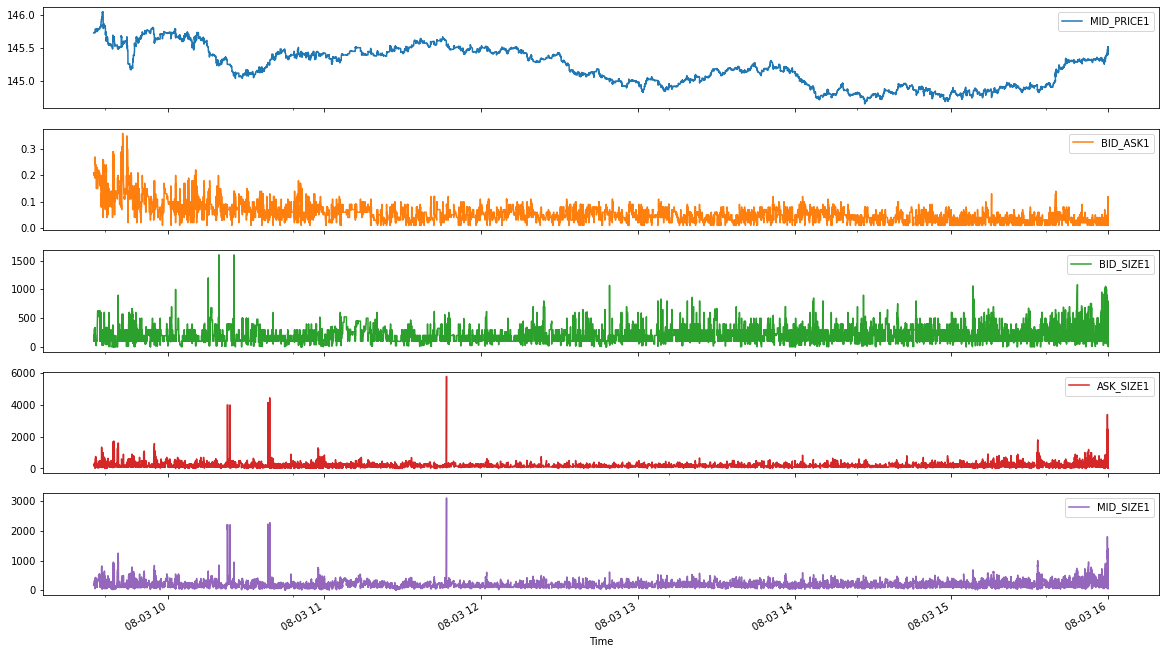

In [164]:
data.loc[:, 'MID_PRICE1'] = 0.5 * (data["BID_PRICE1"] + data["ASK_PRICE1"])
data.loc[:, 'MID_SIZE1'] = 0.5 * (data["BID_SIZE1"] + data["ASK_SIZE1"])
data.loc[:, 'BID_ASK1'] = data["ASK_PRICE1"] - data["BID_PRICE1"]
data.loc[:, ['MID_PRICE1', 'BID_ASK1', 'BID_SIZE1', 'ASK_SIZE1', 'MID_SIZE1']].iloc[100:,:].plot(subplots = True, figsize = (20, 12));

In [165]:
def MA_technical(data, l, s, b):
    dt = data['MID_PRICE1'].values
    return moving_average_signal(dt, l, s, b)

def MP_technical(data, l, s, b):
    dt = data['MID_PRICE1'][-(l+1):]
    dt = (dt.diff() / dt.shift())[1:]
    return moving_average_signal(dt, l, s, b)

def MV_technical(data, l, s, b):
    dt = data['MID_SIZE1'][-(l+1):]
    dt = (dt.diff() / dt.shift())[1:]
    return moving_average_signal(dt, l, s, b)

def moving_average_signal(data, l, s, b):
#     print(np.mean(data[-s:]), np.mean(data[-l:]))
    try:
        ma_ratio = np.mean(data[-s:])/np.mean(data[-l:])
    except:
        ma_ratio = 0
    return 1 if ma_ratio > (1 + b) else (-1 if ma_ratio < (1 - b) else 0)

In [172]:
def add_signals(signal_data, data, signal_func_dict, l, s, b):
    for i, time in enumerate(signal_data.index):
        dt = data.loc[:time,:]
        for signal_name, signal_func in signal_func_dict.items():
            signal_data.loc[time, signal_name] = signal_func(dt, l, s, b)
    signal_data.loc[signal_data.index.strftime('%H:%M:%S') >= "15:50:00",:] = -1
    return signal_data

signal_df = pd.DataFrame(index = pd.date_range(start = np.min(data.index), end = np.max(data.index), freq = '30S'))
signal_df = add_signals(signal_df, data, {'MA': MA_technical, 'MP': MP_technical, 'MV': MV_technical},
                    60, 30, 0.0001)

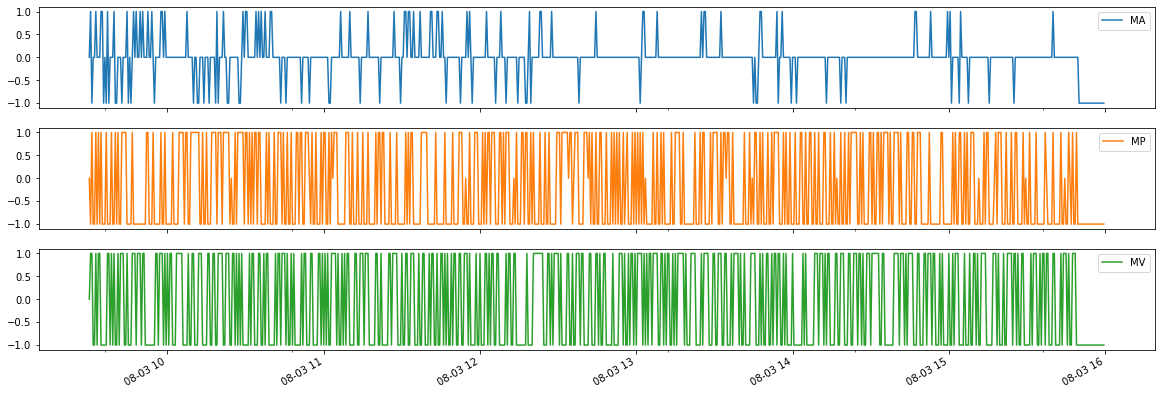

In [173]:
signal_df.plot(subplots = True, figsize = (20, 7));

In [174]:
def get_portfolio(data, signal, delay_s = 0):
    portfolio = pd.DataFrame(index = signal.index, columns = ['Cash', 'Security'])
    cash, security, value = np.array([0] * portfolio.shape[0]), np.array([0] * portfolio.shape[0]), np.array([0] * portfolio.shape[0])
    exec_time = (portfolio.index + pd.to_timedelta(delay_s, unit='s')).values
    cash[0], security[0], value[0] = start_investment, 0, start_investment
    for i, time in enumerate(portfolio.index[1:]):
        i = i+1
        last_data = data.loc[:exec_time[i], :].iloc[-1,:]
        if signal[time] == 0:
            cash[i], security[i] = cash[i-1], security[i-1]
        elif signal[time] == 1:
            security_bought = min(int(cash[i-1]/last_data['ASK_PRICE1']), last_data['ASK_SIZE1'])
            cash[i], security[i] = cash[i-1] - security_bought*last_data['ASK_PRICE1'], security[i-1] + security_bought
        else:
            security_sold = min(security[i-1], last_data['BID_SIZE1'])
            cash[i], security[i] = cash[i-1] + security_sold*last_data['BID_PRICE1'], security[i-1] - security_sold
            
        price = last_data['BID_PRICE1']
        value[i] = cash[i] + security[i]*last_data['BID_PRICE1']
    
    portfolio.loc[:, 'Cash'] = cash
    portfolio.loc[:, 'Security'] = security
    portfolio.loc[:, 'Value'] = value
    return portfolio

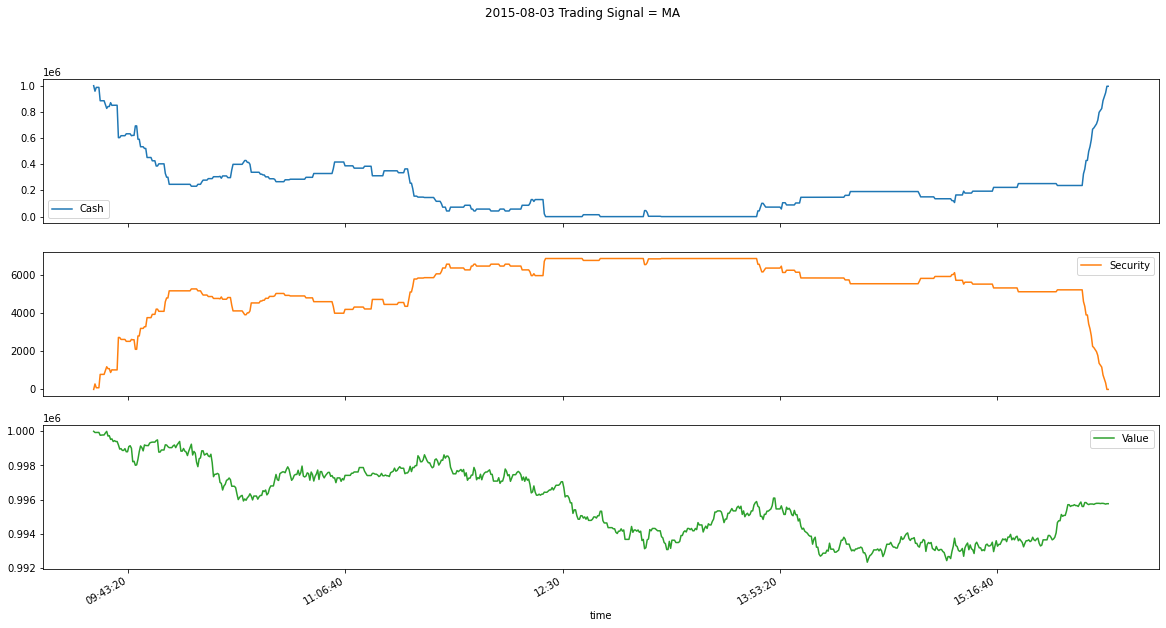

In [175]:
def plot_portfolio(data, signal_df, signal_name, delay = 0):
    portfolio = get_portfolio(data, signal_df[signal_name], delay)
    title = str(portfolio.index.date[0]) + ' Trading Signal = ' + signal_name
    portfolio.index = portfolio.index.time
    portfolio.plot(subplots = True, figsize = (20, 10));
    plt.suptitle(title)

plot_portfolio(data, signal_df, 'MA')

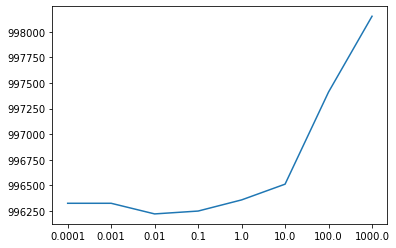

In [176]:
delays = 10.0 ** np.arange(-4, 4)
final_values = list(map(lambda x: get_portfolio(data, signal_df['MP'], x).iloc[-1,2], delays))
plt.plot(list(map(lambda x: str(x), delays)), final_values)